In [48]:
import numpy as np
import matplotlib.pyplot as plt
import densityModel as dm
import torch
from mpl_toolkits.mplot3d import Axes3D
import timeit

%matplotlib notebook
%matplotlib notebook

In [61]:
verbose = True
validat = False
savedata = True
GPU_all = False

if GPU_all:
    torch.set_default_tensor_type('torch.cuda.FloatTensor') 
    # use gpu for everything
else:
    torch.set_default_tensor_type('torch.FloatTensor') 
    # use cpu for everything

# initialize
photon_N = 20
steps_N = 2000
t_delta = 0.001
start_r = 1.5 # in solar radii
start_theta = 0 # in rad
start_phi  = 0 # in rad

r_Sun = 6.96e10 # [cm]
c = 2.998e10    # [cm s^(-1)]
c_r=c/r_Sun     # [s^(-1)]

f_ratio  = 2
density_r = dm.leblanc98 # [cm^(-3)] 
# use saito77 for this calculation 

@torch.enable_grad()
def omega_pe_r(r):
    # Ne with plasma frequency density relationship
    return 8.98e3* (density_r(r))**0.5 * 2 * np.pi

@torch.enable_grad()
def v_abs(v): # length of the vector
    # for torch tensor in shape 3*N
    return torch.sqrt(torch.sum(v.pow(2),axis=0))
    

freq0 = f_ratio * omega_pe_r(start_r)/(2*np.pi)

if verbose:
    print('Frequency(MHz) : '+str(freq0/1e6))
    print('Omega(M rad/s) : '+str(f_ratio * omega_pe_r(start_r)/1e6))

rxx = start_r * np.sin(start_theta) * np.cos(start_phi) * np.ones(photon_N)
ryy = start_r * np.sin(start_theta) * np.sin(start_phi) * np.ones(photon_N)
rzz = start_r * np.cos(start_theta) * np.ones(photon_N)
# [r_sun]


Frequency(MHz) : 50.734577172446606
Omega(M rad/s) : 318.7747498558854


In [62]:

omega0 = freq0*(2*np.pi) # [Hz]
kc0 = np.sqrt(omega0**2. - omega_pe_r(start_r)**2.)

#k_mu0  = np.random.uniform(low=-0.999 ,high=1,size=photon_N) # k_z > 0 use [low = 0]
k_mu0  = np.linspace(-0.999,1,photon_N)
k_phi0 = np.random.uniform(low=-np.pi/1e7 ,high= np.pi/1e7, size=photon_N) 

kc_xx = kc0 * np.sqrt(1-k_mu0**2.) * np.cos(k_phi0)
kc_yy = kc0 * np.sqrt(1-k_mu0**2.) * np.sin(k_phi0)
kc_zz = kc0 * k_mu0

kc_vec = torch.tensor(([kc_xx,kc_yy,kc_zz]))
r_vec = torch.tensor(([rxx,ryy,rzz]),requires_grad=True)

start = timeit.default_timer()

data_saved = []

for idx_t in np.arange(steps_N):
    r_vec.requires_grad_(True)
    rr = v_abs(r_vec)
    omega_pe_xyz = omega_pe_r(rr)
    omega_pe_xyz.backward(omega_pe_xyz*0+1) # for the gradient of omega
    domega_pe_dxyz = r_vec.grad.data
    
    with torch.no_grad(): # update r and k without grad track
        r_vec=r_vec.detach() # also detach main var r_vec
        
        if validat:
            domega_pe_dxyz_explicit = ( 8.98e3/2/((density_r(rr).repeat(3,1))**(0.5))
                * dm.dndr_leblanc98(rr).repeat(3,1)
                * r_vec/rr.repeat(3,1) ) *2 *np.pi
            print("Relative error : " +str(torch.mean(torch.abs(domega_pe_dxyz_explicit-domega_pe_dxyz)/domega_pe_dxyz_explicit)))

            
        dr_dt  = c_r * kc_vec / omega0
        dkc_dt = - omega_pe_xyz.repeat(3,1)/omega0 * domega_pe_dxyz /c_r 

        r_vec = r_vec + dr_dt*t_delta
        kc_vec = kc_vec + dkc_dt*t_delta
        
        # to conserve the frequency
        kc_vec = kc_vec * (torch.sqrt(omega0**2. - omega_pe_r(rr)**2.) / 
                           v_abs(kc_vec)).repeat(3,1)
        
        data_saved.append(np.array(r_vec))

        

stop = timeit.default_timer()
data_saved = np.array(data_saved)
print('Time: ', stop - start)  

Time:  2.1907707999999957


In [63]:
data_saved = np.array(data_saved)

In [64]:
for ray_idx in np.arange(photon_N):
    plt.plot(data_saved[:,0,ray_idx],data_saved[:,2,ray_idx],color='r')
plt.gca().set_aspect('equal')

In [24]:
a=plt.hist(kc_vec[2].cpu().detach(),bins=100)

In [25]:
a=plt.hist(r_vec[2,:].cpu().detach(),bins=100)

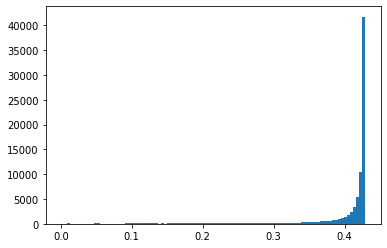

In [25]:
b=plt.hist(v_abs(dr_dt).cpu().detach(),100)

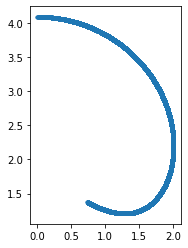

In [26]:
plt.scatter(r_vec.cpu()[0],r_vec.cpu()[2],marker='.')
plt.gca().set_aspect('equal')

In [157]:
c_r

0.4307471264367816

In [158]:
dkc_dt[2,:]

tensor([  7.4160,  65.4785,   9.8064,  ...,      nan, 111.0654,      nan],
       dtype=torch.float64)

In [146]:
kc0

array([6.05617334e+08, 6.05617334e+08, 6.05617334e+08, ...,
       6.05617334e+08, 6.05617334e+08, 6.05617334e+08])